[3839.0]
Point(coordinates=array([-1.57172778e-162,  1.00000000e+001,  9.88131292e-324]))


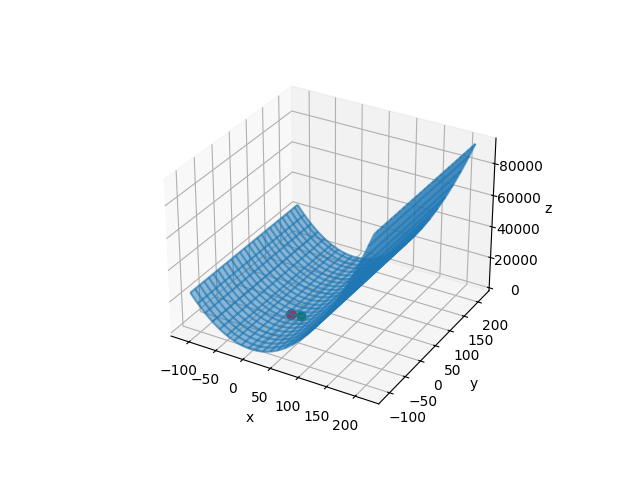

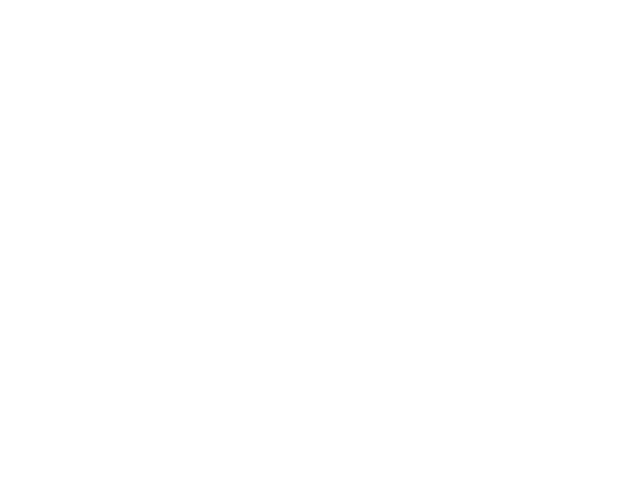

In [1]:
%matplotlib widget
from src.metric import CallCount
from src.common.oracul import LambdaOracul, PoweredSumOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import RandomMethod, GoldenRatioMethod, GradientDescent, GradientDescentWithFixedRate

import matplotlib.pyplot as plt

fig = plt.figure()

method = RandomMethod()
golden_ratio = GoldenRatioMethod()
gradient_descent = GradientDescent()
oracul = LambdaOracul(lambda x: (x - 10) ** 2)
test_oracul = PoweredSumOracul([[2, 2], [0, 2]])
point, metrics, anim = MethodProcessor.process(gradient_descent, test_oracul, CountCondition(20), metrics=[CallCount()], method_params = {"x":np.array([20, 10]), 'learning_rate':0.0001}, visualize=True,
                                               low_bracket=[-100, -100], high_bracket=[200, 200])
print(metrics)
print(point)
plt.show()